In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.metrics import silhouette_score

%matplotlib inline

#  Load the Data

In [3]:
df = pd.read_csv("cleaned_plyear_data.csv")
df = df[['Position', 'Age', 'Appearances', 'Goals']]
df = pd.get_dummies(df, columns=['Position'])


In [49]:
df

,Age,Appearances,Goals,Position_Attack Centre-Forward,Position_Attack-LeftWinger,Position_Attack-RightWinger,Position_Attack-SecondStriker,Position_Defender Centre-Back,Position_Defender Left-Back,Position_Defender Right-Back,Position_Goalkeeper,Position_midfield-AttackingMidfield,Position_midfield-CentralMidfield,Position_midfield-DefensiveMidfield,Position_midfield-LeftMidfield,Position_midfield-RightMidfield,dbscan
0,30.0,15,0.000000,False,False,False,False,False,False,False,True,False,False,False,False,False,0
1,37.0,4,0.000000,False,False,False,False,False,False,False,True,False,False,False,False,False,0
2,31.0,8,0.000000,False,False,False,False,True,False,False,False,False,False,False,False,False,1
3,21.0,34,0.000000,False,False,False,False,True,False,False,False,False,False,False,False,False,1
4,23.0,89,0.012619,False,False,False,False,False,True,False,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,20.0,16,0.175953,False,False,True,False,False,False,False,False,False,False,False,False,False,5
10299,24.0,26,0.372671,True,False,False,False,False,False,False,False,False,False,False,False,False,6
10300,19.0,20,0.375000,True,False,False,False,False,False,False,False,False,False,False,False,False,6
10301,20.0,17,0.312139,True,False,False,False,False,False,False,False,False,False,False,False,False,6


In [51]:
df.columns


Index(['Age', 'Appearances', 'Goals', 'Position_Attack Centre-Forward',
       'Position_Attack-LeftWinger', 'Position_Attack-RightWinger',
       'Position_Attack-SecondStriker', 'Position_Defender Centre-Back',
       'Position_Defender Left-Back', 'Position_Defender Right-Back',
       'Position_Goalkeeper', 'Position_midfield-AttackingMidfield',
       'Position_midfield-CentralMidfield',
       'Position_midfield-DefensiveMidfield', 'Position_midfield-LeftMidfield',
       'Position_midfield-RightMidfield', 'dbscan'],
      dtype='object')

# Data Scaling
- Selecting relevant features.
- Separating the target variable.
- Standardizing the feature values to have a mean of 0 and a standard deviation of 1.

In [5]:
# Data Preparation
X = df

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Perform Nearest Neighbors to choose eps

In [7]:
min_samples = 2
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)
k_dist = distances[:, min_samples-1]
k_dist_sorted = np.sort(k_dist)

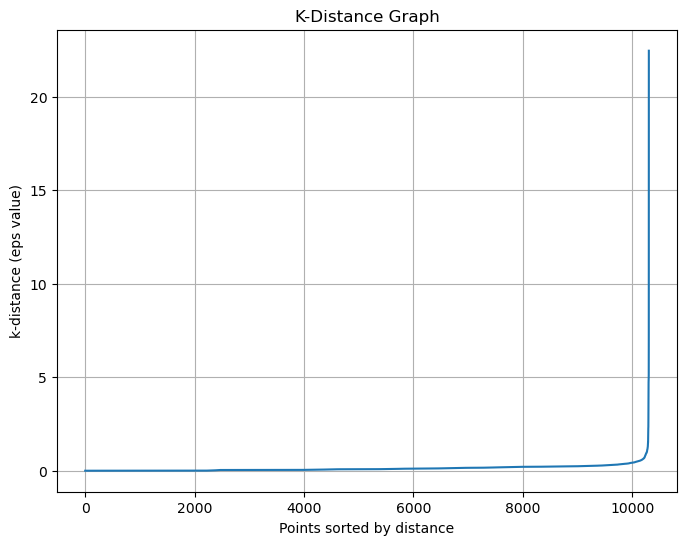

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()


#  Hyperparameter Tuning for DBSCAN

In [10]:
param_grid_dbscan = {
    'eps': np.arange(0.1, 2.1, 0.1),
    'min_samples': [2, 3, 4, 5, 6]
}

best_score = -1
best_params_dbscan = {'eps': None, 'min_samples': None}


# Grid search for DBSCAN

In [12]:
for eps in param_grid_dbscan['eps']:
    for min_samples in param_grid_dbscan['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)
        # Evaluate the model using silhouette score
        if len(set(clusters)) > 1:  # Check if more than one cluster
            score = silhouette_score(X_scaled, clusters)
            if score > best_score:
                best_score = score
                best_params_dbscan['eps'] = eps
                best_params_dbscan['min_samples'] = min_samples

print(f'Best Parameters for DBSCAN: {best_params_dbscan}')
print(f'Best Silhouette Score: {best_score}')


Best Parameters for DBSCAN: {'eps': 1.9000000000000001, 'min_samples': 6}
Best Silhouette Score: 0.6056612385371707


# Train the model with best parameters

In [14]:
chosen_eps = best_params_dbscan['eps']
chosen_min_samples = best_params_dbscan['min_samples']
dbscan = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples)
clusters = dbscan.fit_predict(X_scaled)


# Plot the results

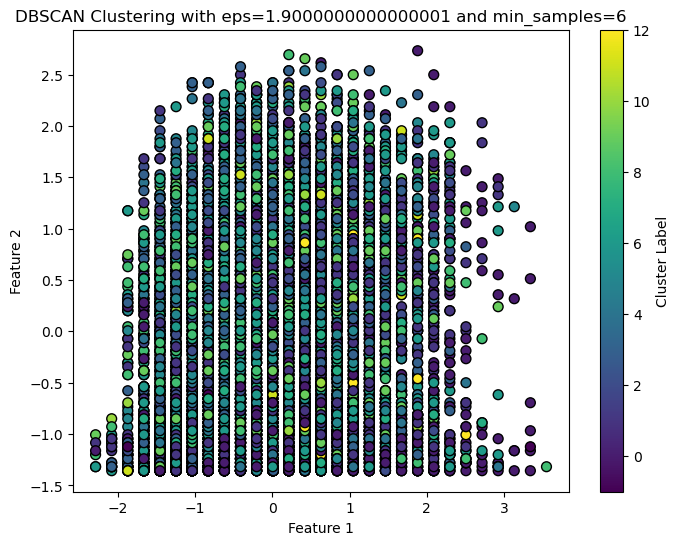

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps} and min_samples={chosen_min_samples}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()


# Add cluster labels to the DataFrame

In [18]:
X['dbscan'] = clusters

# Display cluster counts
print(X['dbscan'].value_counts())


dbscan
 1     1774
 6     1331
 0     1208
 3     1154
 9      857
 7      845
 2      781
 8      737
 5      676
 4      668
 10     100
 11      96
 12      54
-1       22
Name: count, dtype: int64


# Visualize clusters

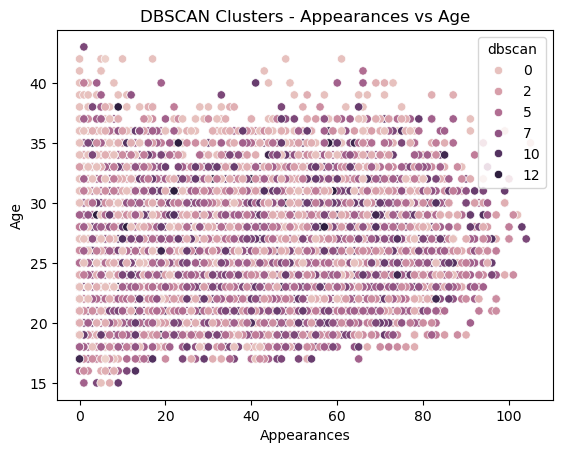

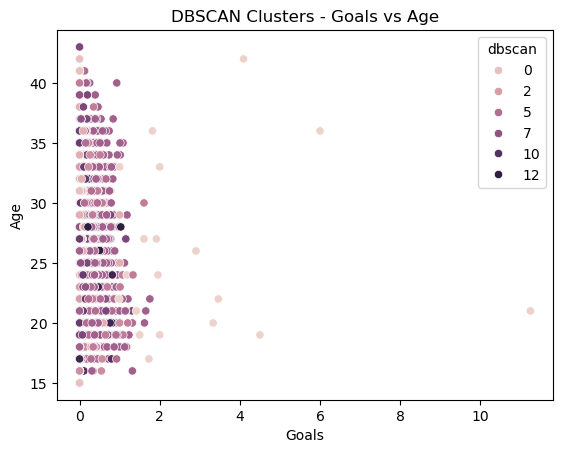

In [20]:
sns.scatterplot(data=X, x='Appearances', y='Age', hue='dbscan')
plt.title('DBSCAN Clusters - Appearances vs Age')
plt.show()

sns.scatterplot(data=X, x='Goals', y='Age', hue='dbscan')
plt.title('DBSCAN Clusters - Goals vs Age')
plt.show()


In [61]:
from fastapi.encoders import jsonable_encoder
json_compatible_data = jsonable_encoder(dict_f)

In [59]:
dict_f = {
         'Age': 30,
    'Appearances': 15,
    'Goals': 20,
    'Position_Attack Centre-Forward': False,
    'Position_Attack-LeftWinger': False,
    'Position_Attack-RightWinger': False,
    'Position_Attack-SecondStriker': True,
    'Position_Defender Centre-Back': False,
    'Position_Defender Left-Back': False,
    'Position_Defender Right-Back': False,
    'Position_Goalkeeper': False,
    'Position_midfield-AttackingMidfield': False,
    'Position_midfield-CentralMidfield': False,
    'Position_midfield-DefensiveMidfield': False,
    'Position_midfield-LeftMidfield': False,
    'Position_midfield-RightMidfield': False
             }
scaler.transform(np.array([list(dict_f.values())]))

array([[ 0.83973986, -0.77265839, 84.16724397, -0.38632509, -0.26372823,
        -0.26519871, 13.52708922, -0.45606606, -0.28678895, -0.29909454,
        -0.3644451 , -0.27817544, -0.35532676, -0.30159115, -0.09698098,
        -0.09949884]])

In [63]:
np.array([list(dict_f.values())])

array([[30, 15, 20,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [65]:
import joblib
joblib.dump(dbscan, 'dbscan_model.joblib')
joblib.dump(scaler, 'dbscan_scaler.joblib')

['dbscan_scaler.joblib']